In [29]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from PIL import Image
import glob

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from dataset_custom import CustomDataset
paths_train = []
paths_valid = []
train_valid_split = 0.85

"""
The imagines with name 01 at last are the ones with the noise
those we will use to train the model
"""
for path in glob.glob('sigma2p5stripe500Gau0p01Pepper0p005/*'):
    if '01.png' not in path:
        continue
    if np.random.rand() < train_valid_split:
        paths_train.append(path)
    else:
        paths_valid.append(path)
# print(paths_train)

In [4]:
train_ds = CustomDataset(paths_train) 
valid_ds = CustomDataset(paths_valid)

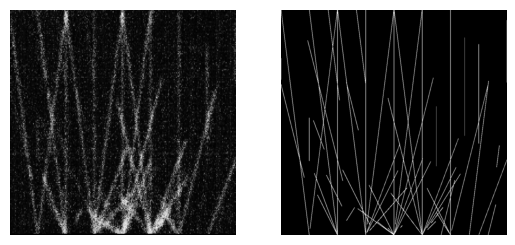

In [5]:
""" 
plot the first image with its target image in the dataset side by side
"""
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_ds[0][0].squeeze(), cmap='gray')
ax[0].axis('off')
ax[1].imshow(train_ds[0][1].squeeze(), cmap='gray')
ax[1].axis('off')
plt.show()

In [6]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=20, shuffle=True)

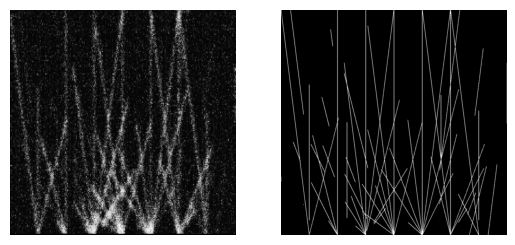

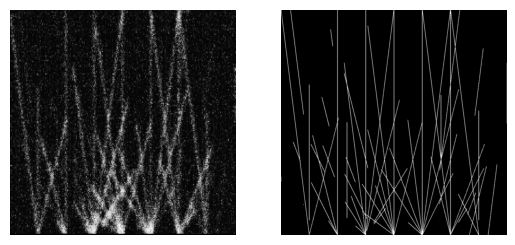

In [7]:
""" 
plot the first target image and the predicted image side by side
"""

from model_denoise import logarithmic_stretching, gamma_stretch, midtone_stretch

for xb, yb in train_dl:  # train_dl[][] 中的第二个[]被拆开成xb, yb
    # Move tensors to 'mps:0' for processing
    xb_mps = xb.to('mps:0')
    yb_mps = yb.to('mps:0')
    
    # Apply the logarithmic_stretching function and move the result back to CPU for plotting
    stretched_xb = gamma_stretch(xb_mps[0]).to('cpu').squeeze().numpy()
    
    # Move the yb tensor back to CPU for plotting
    yb_cpu = yb_mps[0].to('cpu').squeeze().numpy()
    
    # Plotting the stretched image and the original yb image
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(stretched_xb, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(yb_cpu, cmap='gray')
    ax[1].axis('off')
    
    # Plotting the original xb image and the original yb image
    xb_cpu = xb_mps[0].to('cpu').squeeze().numpy()
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(xb_cpu, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(yb_cpu, cmap='gray')
    ax[1].axis('off')
    
    break

In [8]:
from model_denoise import DenoiseAutoencoder
net = DenoiseAutoencoder()

In [9]:
from train_loss import train_valid_loop

In [10]:
train_loss, valid_loss = train_valid_loop(net, train_dl, valid_dl, Nepochs=35, learning_rate=1e-3)

Found MPS!


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch:  0  Train loss:  0.06144309611144391  Valid loss:  0.0326812407001853
Model saved!
Epoch:  1  Train loss:  0.029517501931298862  Valid loss:  0.030398075468838215
Model saved!
Epoch:  2  Train loss:  0.028415297158062458  Valid loss:  0.02883497206494212
Model saved!
Epoch:  3  Train loss:  0.02759819020601836  Valid loss:  0.027883772738277912
Model saved!
Epoch:  4  Train loss:  0.026258082721721043  Valid loss:  0.02632895903661847
Model saved!
Epoch:  5  Train loss:  0.02464774064719677  Valid loss:  0.025824952870607376
Model saved!
Epoch:  6  Train loss:  0.021818017163737255  Valid loss:  0.02299073012545705
Model saved!
Epoch:  7  Train loss:  0.019583412615413017  Valid loss:  0.019672472961246967
Epoch:  8  Train loss:  0.017762925983829933  Valid loss:  0.020015519578009844
Model saved!
Epoch:  9  Train loss:  0.016268684528768063  Valid loss:  0.017367432359606028
Model saved!
Epoch:  10  Train loss:  0.014911647505042229  Valid loss:  0.016387668438255787
Model save

In [11]:
train_loss, valid_loss = train_valid_loop(net, train_dl, valid_dl, Nepochs=30, learning_rate=1e-4)

Found MPS!


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  0  Train loss:  0.005037885751913895  Valid loss:  0.005413125385530293
Model saved!
Epoch:  1  Train loss:  0.004928509090942415  Valid loss:  0.005287364940159023
Epoch:  2  Train loss:  0.004899539201605049  Valid loss:  0.005359039758332074
Epoch:  3  Train loss:  0.004838957006789066  Valid loss:  0.005324162659235299
Epoch:  4  Train loss:  0.004820102402432399  Valid loss:  0.0053223983850330114
Epoch:  5  Train loss:  0.004783988528122956  Valid loss:  0.005335836671292782
Model saved!
Epoch:  6  Train loss:  0.004734304479577325  Valid loss:  0.005138933309353888
Epoch:  7  Train loss:  0.004694500006735325  Valid loss:  0.005200253566727042
Model saved!
Epoch:  8  Train loss:  0.004654811060225422  Valid loss:  0.005008658743463457
Epoch:  9  Train loss:  0.004604512021284212  Valid loss:  0.005133955623023212
Epoch:  10  Train loss:  0.004606968511573293  Valid loss:  0.0051324451342225075
Model saved!
Epoch:  11  Train loss:  0.004551970717412504  Valid loss:  0.005

In [173]:
from model_denoise import DenoiseAutoencoder
model = DenoiseAutoencoder()
model.load_state_dict(torch.load('models_saved/saved_model_gamma_onlatent_1.pt'))

<All keys matched successfully>

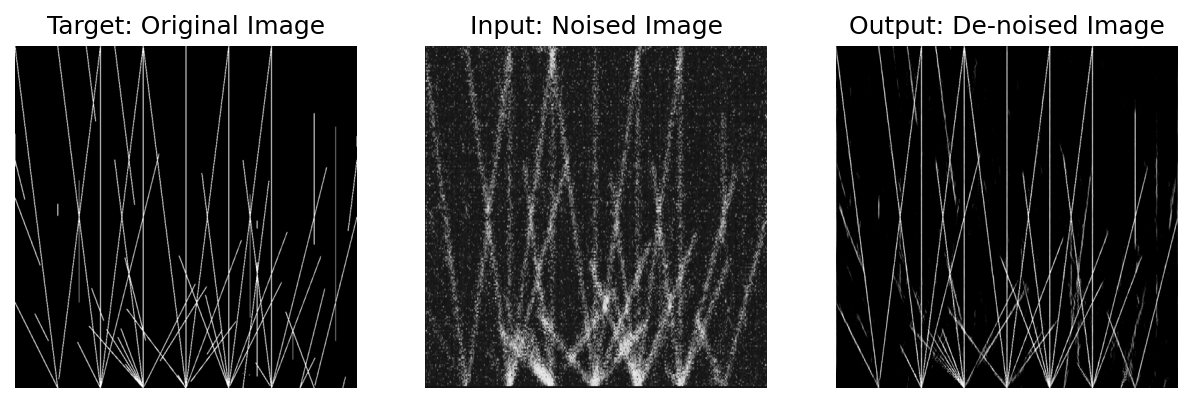

In [174]:
x, y = valid_ds[-1]
device = 'mps'  
model.to(device)
x_mps = x.unsqueeze(0).to(device)

# Now, perform the forward pass
xprime = model(x_mps).detach()
xprime_cpu = xprime.cpu().numpy()

fig,ax = plt.subplots(1,3,figsize=(10,3),dpi=150)

ax[0].imshow(y.squeeze(0),cmap='Greys_r',vmin=0,vmax=1)
ax[0].set_title('Target: Original Image')
ax[1].imshow(x.squeeze(0),cmap='Greys_r',vmin=0,vmax=1)
ax[1].set_title('Input: Noised Image')
ax[2].imshow(xprime_cpu.squeeze(),cmap='Greys_r',vmin=0,vmax=1)
ax[2].set_title('Output: De-noised Image')

for i in range(3):
    ax[i].set_axis_off()

plt.show()

In [ ]:
x, y = valid_ds[-1]
device = 'mps'  
net.to(device)
x_mps = x.unsqueeze(0).to(device)

# Now, perform the forward pass
xprime = net(x_mps).detach()
xprime_cpu = xprime.cpu().numpy()


fig,ax = plt.subplots(1,2,dpi=150)

ax[0].imshow(y.squeeze(0),cmap='Greys_r',vmin=0,vmax=1)
ax[0].set_title('Target: Original Image')
# ax[1].imshow(x.squeeze(0),cmap='Greys_r',vmin=0,vmax=1)
# ax[1].set_title('Input: Noised Image')
ax[1].imshow(xprime_cpu.squeeze(),cmap='Greys_r',vmin=0,vmax=1)
ax[1].set_title('Output: De-noised Image')

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [199]:
import cv2
def thicken_lines(img, kernel_size=(2,2), iterations=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    dilated_img = cv2.dilate(img, kernel, iterations=iterations)
    return dilated_img

(32, 1, 2)


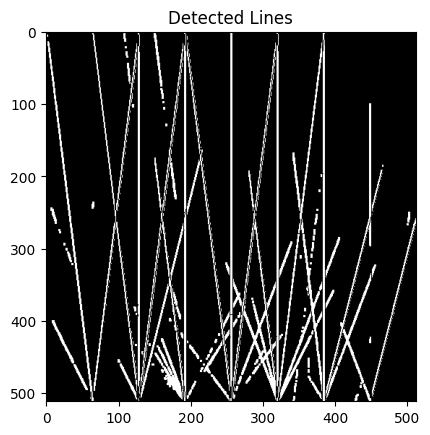

In [200]:

gray = xprime_cpu.squeeze()
gray = thicken_lines(gray)
gray = cv2.convertScaleAbs(gray)
edges = cv2.Canny(gray, 50, 100, apertureSize=7)

# linesP = cv2.HoughLinesP(gray, 1, np.pi/180, 70, minLineLength=20, maxLineGap=100)
# if linesP is not None:
#     for line in linesP:
#         x1, y1, x2, y2 = line[0]
#         cv2.line(gray, (x1, y1), (x2, y2), (0, 255, 0), 2)


# Using HoughLines method
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
print(lines.shape)

if lines is not None:
    for rho, theta in lines[:,0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(gray, (x1, y1), (x2, y2), (0, 0, 255),1)


# # Display the result
plt.imshow(gray, cmap='gray')
plt.title('Detected Lines')
plt.show()
# plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
# plt.title('Detected Lines')
# plt.show()
# thickened_image = thicken_lines(gray)
# thickened_image = cv2.convertScaleAbs(thickened_image)
# plt.imshow(thickened_image, cmap='gray')


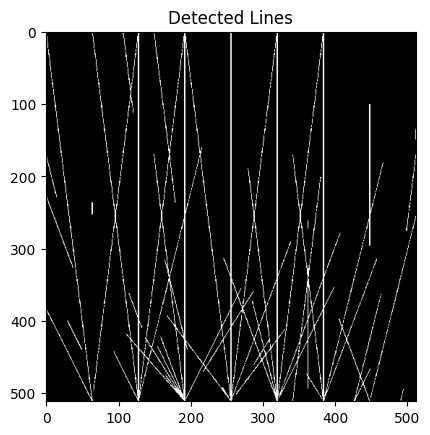

In [198]:
ygray = y.squeeze().numpy()
yggray = thicken_lines(ygray)
# yggray = cv2.convertScaleAbs(yggray)
ygray = cv2.convertScaleAbs(ygray)
yedges = cv2.Canny(ygray, 50, 100, apertureSize=3)

# linesP = cv2.HoughLinesP(gray, 1, np.pi/180, 70, minLineLength=20, maxLineGap=100)
# if linesP is not None:
#     for line in linesP:
#         x1, y1, x2, y2 = line[0]
#         cv2.line(gray, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Using HoughLines method
ylines = cv2.HoughLines(yedges, 1, np.pi/180, 200)

# Step 4: Draw the Detected Lines
# Drawing lines from HoughLines
if ylines is not None:
    for rho, theta in ylines[:,0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(ygray, (x1, y1), (x2, y2), (0, 0, 255), 3)


# # Display the result
plt.imshow(ygray, cmap='gray')
plt.title('Detected Lines')
plt.show()